In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import sys
import copy
import cv2
from imp import reload
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

### Extract tracks from first database

In [2]:
nPosts = 2
window_size = 50
isolation_type = 'short_noise' # this determines which tracks we heatmap with. It can be 'signal', 'short_noise' or 'long_noise'
spatial_discretisation_step = 0.01

dataDIR = '/mnt/ssd1/Documents/Vivek/locustVR/databases/data_collection/'
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_20_01_07.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_20_01_07.db'

In [3]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

In [4]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('c0127c9b-3ff9-4c49-8db4-6900ff4c2b2a',), ('54a35a9f-9eb0-4404-bc9d-8ed7b71192c5',), ('7ac51c48-5f5a-4ac3-9930-56772578c1ee',), ('3a1d5deb-e8f7-48a4-aabb-25456f941c43',), ('752b3218-e802-47e8-bbc6-1049f15e6f85',), ('13e69b2f-9760-4625-a309-511af2c5afb2',), ('2a7c4e5b-deb9-4c55-b0f7-2547034b8b4d',), ('da620536-7437-4bf6-a7de-ba36f19b4177',), ('acb6ec35-e1e0-450a-98ca-581b0f21723e',), ('1730f55c-ba6b-467b-96a8-f23c387f2905',), ('a57b486a-c26a-4016-9722-56846965487e',), ('ded361ec-3214-458a-858f-1be11809fd14',), ('8f13a403-e1bd-4adf-9a4a-ef18b2e4915e',), ('8e0cb790-55be-46b5-be17-f92c2208f12d',), ('5cb7d44f-5166-46ce-b317-f4bd8d3267c5',), ('9e41ebbd-fadd-4ea5-8457-77c541faa137',), ('e62178c9-e0f0-4970-82b6-e26225576f3b',), ('19c69caf-3dc5-4cf4-950c-95acad45ecd9',), ('a678f783-103d-4485-a995-78d7f6b9824e',), ('43f0818a-bae1-44ca-bef9-8823bb8c8ab9',), ('5e103a3b-105b-4820-92e1-b2c2cf2c11ee',), ('2292bbb7-d520-4715-a948-dbd7422e6660',), ('125adcc5-4f9b-47ba-9849-53aa901c5442',), 

In [5]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = np.nan
    tmp['nStimuli'] = np.uint8(tmp['nStimuli'])
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            start_x = tmp2.loc[0,'x']
            start_y = tmp2.loc[0,'y']
            for k in range(1,len(tmp2)):
                x = tmp2.loc[k,'x']
                y = tmp2.loc[k,'y']
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k,'selected'] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
    
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [6]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.nanmax(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]

# initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = 0.0
df['ang'] = 0.0
prerot_idx = 9+2*nPosts
postrot_idx = 9+2*nPosts+2+2*nPosts

In [7]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.iloc[np.where(df['uuid'] == uuid)[0],postrot_idx+1] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    if len(np.unique(df.loc[df['uuid'] == uuid,'nStimuli'])) != 0:
        for i in np.unique(df.loc[df['uuid'] == uuid,'nStimuli']):
            ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
            if i > 0 and i < np.max(nStimuli): 
                ang += (nPosts-1)*eval(dataDict0[uuid][nStimuli[i]][0])['angle']/2

            rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

            rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

            rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))

In [8]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)
if nPosts == 2:
    df['dmin'] = np.nanmin([p0_dist, p1_dist], axis=0)
    df['post'] = 0
    df.loc[p1_dist < p0_dist, 'post'] = 1
else:
    p2_dist = np.sqrt((df['x'] - df['post2_x'])**2 + (df['y'] - df['post2_y'])**2)
    df['dmin'] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
    df['post'] = 0
    df.loc[(p1_dist < p0_dist) & (p1_dist < p2_dist), 'post'] = 1
    df.loc[(p2_dist < p0_dist) & (p2_dist < p1_dist), 'post'] = 2

In [9]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 0.5]
dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [10]:
tmp0 = df[df['nStimuli'] == 0]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[0])]
tmp2 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[1])]
tmp3 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[2])]
tmp4 = df[df['nStimuli'] == 4]

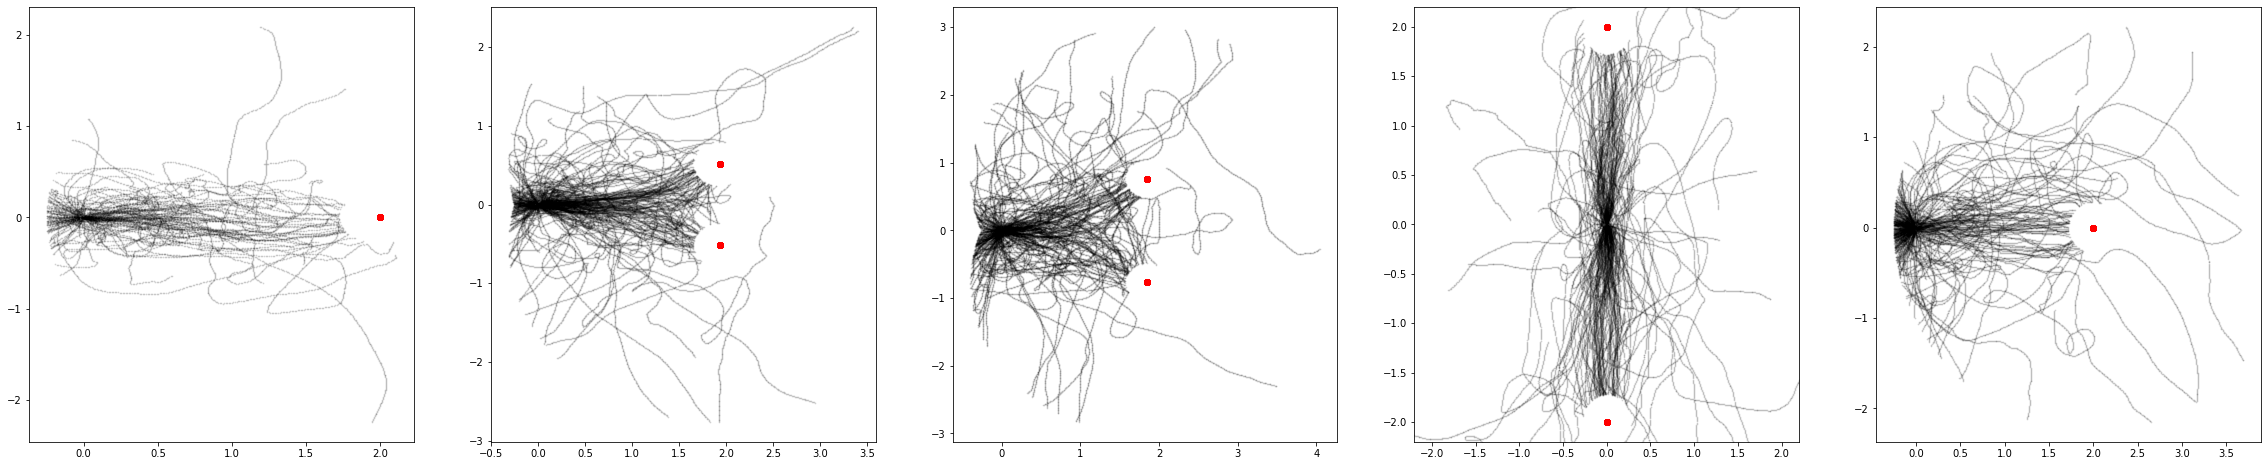

In [11]:
fig, ax = plt.subplots(1, 5, figsize = (40,8))
ax[0].scatter(tmp0['rotated_x'], tmp0['rotated_y'], c='black', s=1, alpha=0.1)
ax[0].scatter(tmp0['rotated_post0_x'], tmp0['rotated_post0_y'], c='red')

ax[1].scatter(tmp1['rotated_x'], tmp1['rotated_y'], c='black', s=1, alpha=0.1)
ax[1].scatter(tmp1['rotated_post0_x'], tmp1['rotated_post0_y'], c='red')
ax[1].scatter(tmp1['rotated_post1_x'], tmp1['rotated_post1_y'], c='red')

ax[2].scatter(tmp2['rotated_x'], tmp2['rotated_y'], c='black', s=1, alpha=0.1)
ax[2].scatter(tmp2['rotated_post0_x'], tmp2['rotated_post0_y'], c='red')
ax[2].scatter(tmp2['rotated_post1_x'], tmp2['rotated_post1_y'], c='red') 

ax[3].scatter(tmp3['rotated_x'], tmp3['rotated_y'], c='black', s=1, alpha=0.1)
ax[3].scatter(tmp3['rotated_post0_x'], tmp3['rotated_post0_y'], c='red')
ax[3].scatter(tmp3['rotated_post1_x'], tmp3['rotated_post1_y'], c='red')
ax[3].set_xlim(-2.2,2.2)
ax[3].set_ylim(-2.2,2.2)

ax[4].scatter(tmp4['rotated_x'], tmp4['rotated_y'], c='black', s=1, alpha=0.1)
ax[4].scatter(tmp4['rotated_post0_x'], tmp4['rotated_post0_y'], c='red')

In [12]:
df1 = tmp2.loc[:, ['rotated_x', 'rotated_y', 't']]
df1 = df1.reset_index(drop=True)
df1['event'] = 0
df1['t2'] = 0

In [13]:
t = df1.loc[0, "t"]
t2 = df1.loc[0, "t2"]
df1.loc[0, "t"] = df1.loc[0, "t"] - t
df1.loc[0, "t2"] = df1.loc[0, "t2"] - t2

for i in range(1, df1.shape[0]):
    if (
        np.sqrt(
            (df1.loc[i, "rotated_x"] - df1.loc[i - 1, "rotated_x"]) ** 2
            + (df1.loc[i, "rotated_y"] - df1.loc[i - 1, "rotated_y"]) ** 2
        )
        < 0.2
    ):
        df1.loc[i, "event"] = df1.loc[i - 1, "event"]
        df1.loc[i, "t"] = df1.loc[i, "t"] - t
        df1.loc[i, "t2"] = i-1 - t2
    else:
        df1.loc[i, "event"] = df1.loc[i - 1, "event"] + 1
        t = df1.loc[i, "t"]
        t2 = i-1
        df1.loc[i, "t"] = df1.loc[i, "t"] - t
        df1.loc[i, "t2"] = i-1 - t2

In [14]:
x1s = np.array(df1['rotated_x'])
y1s = np.array(df1['rotated_y'])

post0_x = np.unique(tmp2['rotated_post0_x'])[0]
post0_y = np.unique(tmp2['rotated_post0_y'])[0]

post1_x = np.unique(tmp2['rotated_post1_x'])[0]
post1_y = np.unique(tmp2['rotated_post1_y'])[0]

### Extract tracks from second database

In [15]:
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_19_11_28.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_19_11_28_mod.db'

In [16]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('fea86966-c7a8-49f5-bf93-f8a38453e875',), ('32d1f550-279f-4c2a-8456-65483875ad86',), ('a6e70613-9c6b-4417-bc3a-ff0ce95a1ee5',), ('bb9e6a9d-67e1-40de-9f4c-464da0a824ba',), ('353adab2-d51f-4885-adba-508ba2cac467',), ('3a521430-7aa6-412b-8d00-62524874d36a',), ('e3f84ff4-d4b5-415b-9527-5ac834f7cba4',), ('cd75759c-29e2-4ea9-867e-898ee8a02978',), ('fc408072-8c38-4393-83a9-57eade5c057f',), ('b4b1da4d-0aea-4d0c-ba3e-1c113d464135',), ('cc8377c9-e811-40cc-bb67-565e78c0f8bf',), ('e3ce0a89-62ec-47fe-b850-d22b0d0d0527',), ('dd5aac5d-6706-4b09-b50f-bd3cf13cdc91',), ('2f236bc2-25bd-4988-bd6e-f607b9b84f16',), ('19ea8655-cde3-4348-8cb9-8bac6d52668c',), ('209364f5-752f-407b-93c9-b888cd72bed8',), ('d1435f65-5c11-42f9-83db-b222efb9cb46',), ('e60266be-c44d-41a6-a3de-17518bccb1cc',), ('943385e1-c9d0-4f05-bd41-d84bfc3e6760',), ('88f78724-8677-471b-9340-71829d40c2bb',), ('001d9058-7736-4d81-965f-a6daee530e55',), ('06afe132-3a9e-4208-8dcc-b97fb76b927d',), ('1eb32c86-8b1e-4786-a3b4-d87a1299ac21',), 

In [17]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = np.nan
    tmp['nStimuli'] = np.uint8(tmp['nStimuli'])
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            if tmp2.empty != True:
                start_x = tmp2.loc[0,'x']
                start_y = tmp2.loc[0,'y']
                for k in range(1,len(tmp2)):
                    x = tmp2.loc[k,'x']
                    y = tmp2.loc[k,'y']
                    dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                    if dist > spatial_discretisation_step:
                        tmp2.loc[k,'selected'] = 1
                        start_x = x
                        start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
    
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [18]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.nanmax(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]

# initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = 0.0
df['ang'] = 0.0
prerot_idx = 9+2*nPosts
postrot_idx = 9+2*nPosts+2+2*nPosts

In [19]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.iloc[np.where(df['uuid'] == uuid)[0],postrot_idx+1] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    if len(np.unique(df.loc[df['uuid'] == uuid,'nStimuli'])) != 0:
        for i in np.unique(df.loc[df['uuid'] == uuid,'nStimuli']):
            ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
            if i > 0 and i < np.max(nStimuli): 
                ang += (nPosts-1)*eval(dataDict0[uuid][nStimuli[i]][0])['angle']/2

            rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

            rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

            rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))

In [20]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)
if nPosts == 2:
    df['dmin'] = np.nanmin([p0_dist, p1_dist], axis=0)
    df['post'] = 0
    df.loc[p1_dist < p0_dist, 'post'] = 1
else:
    p2_dist = np.sqrt((df['x'] - df['post2_x'])**2 + (df['y'] - df['post2_y'])**2)
    df['dmin'] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
    df['post'] = 0
    df.loc[(p1_dist < p0_dist) & (p1_dist < p2_dist), 'post'] = 1
    df.loc[(p2_dist < p0_dist) & (p2_dist < p1_dist), 'post'] = 2

In [21]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 0.5]
dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [22]:
tmp0 = df[df['nStimuli'] == 0]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[0])]
tmp2 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[1])]
tmp3 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[2])]
tmp4 = df[df['nStimuli'] == 4]

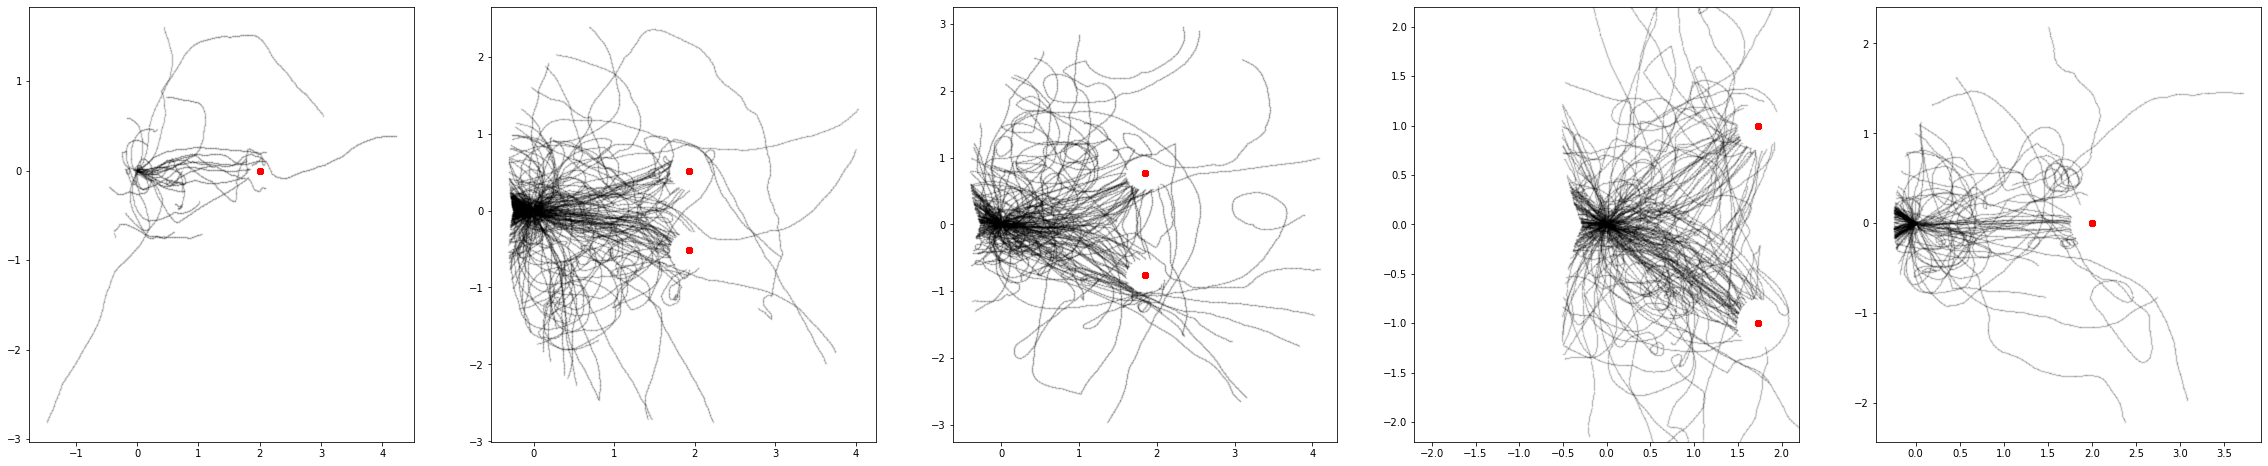

In [23]:
fig, ax = plt.subplots(1, 5, figsize = (40,8))
ax[0].scatter(tmp0['rotated_x'], tmp0['rotated_y'], c='black', s=1, alpha=0.1)
ax[0].scatter(tmp0['rotated_post0_x'], tmp0['rotated_post0_y'], c='red')

ax[1].scatter(tmp1['rotated_x'], tmp1['rotated_y'], c='black', s=1, alpha=0.1)
ax[1].scatter(tmp1['rotated_post0_x'], tmp1['rotated_post0_y'], c='red')
ax[1].scatter(tmp1['rotated_post1_x'], tmp1['rotated_post1_y'], c='red')

ax[2].scatter(tmp2['rotated_x'], tmp2['rotated_y'], c='black', s=1, alpha=0.1)
ax[2].scatter(tmp2['rotated_post0_x'], tmp2['rotated_post0_y'], c='red')
ax[2].scatter(tmp2['rotated_post1_x'], tmp2['rotated_post1_y'], c='red') 

ax[3].scatter(tmp3['rotated_x'], tmp3['rotated_y'], c='black', s=1, alpha=0.1)
ax[3].scatter(tmp3['rotated_post0_x'], tmp3['rotated_post0_y'], c='red')
ax[3].scatter(tmp3['rotated_post1_x'], tmp3['rotated_post1_y'], c='red')
ax[3].set_xlim(-2.2,2.2)
ax[3].set_ylim(-2.2,2.2)

ax[4].scatter(tmp4['rotated_x'], tmp4['rotated_y'], c='black', s=1, alpha=0.1)
ax[4].scatter(tmp4['rotated_post0_x'], tmp4['rotated_post0_y'], c='red')

In [24]:
df2 = tmp2.loc[:, ['rotated_x', 'rotated_y', 't']]
df2 = df2.reset_index(drop=True)
df2['event'] = np.max(df1['event'])+1
df2['t2'] = 0

In [25]:
t = df2.loc[0, "t"]
t2 = df2.loc[0, "t2"]
df2.loc[0, "t"] = df2.loc[0, "t"] - t
df2.loc[0, "t2"] = df2.loc[0, "t2"] - t2

for i in range(1, df2.shape[0]):
    if (
        np.sqrt(
            (df2.loc[i, "rotated_x"] - df2.loc[i - 1, "rotated_x"]) ** 2
            + (df2.loc[i, "rotated_y"] - df2.loc[i - 1, "rotated_y"]) ** 2
        )
        < 0.2
    ):
        df2.loc[i, "event"] = df2.loc[i - 1, "event"]
        df2.loc[i, "t"] = df2.loc[i, "t"] - t
        df2.loc[i, "t2"] = i-1 - t2
    else:
        df2.loc[i, "event"] = df2.loc[i - 1, "event"] + 1
        t = df2.loc[i, "t"]
        t2 = i-1
        df2.loc[i, "t"] = df2.loc[i, "t"] - t
        df2.loc[i, "t2"] = i-1 - t2

In [26]:
x2s = np.array(df2['rotated_x'])
y2s = np.array(df2['rotated_y'])

print(round(post0_x,3) == round(np.unique(tmp2['rotated_post0_x'])[0],3))
print(round(post0_y,3) == round(np.unique(tmp2['rotated_post0_y'])[0],3))

print(round(post1_x,3) == round(np.unique(tmp2['rotated_post1_x'])[0],3))
print(round(post1_y,3) == round(np.unique(tmp2['rotated_post1_y'])[0],3))

True
True
True
True


### Combine tracks and visualise

In [27]:
df = pd.concat((df1,df2))

short_events = list(np.unique(df.loc[df["t2"] > 170, "event"]))
long_events = list(np.unique(df.loc[df["t2"] > 300, "event"]))

df_short = df[~df["event"].isin(short_events)]
df_mid = df[df["event"].isin(short_events)]
df_mid = df_mid[~df_mid["event"].isin(long_events)]
df_long = df[df["event"].isin(long_events)]

In [28]:
if isolation_type == 'signal':
    xs = df_mid['rotated_x']
    ys = df_mid['rotated_y']
    ts = df_mid['t2']
elif isolation_type == 'short_noise':
    xs = df_short['rotated_x']
    ys = df_short['rotated_y']
    ts = df_short['t2']
else:
    xs = df_long['rotated_x']
    ys = df_long['rotated_y']
    ts = df_long['t2']

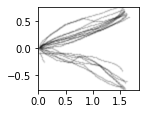

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(post0_x, post1_y * 2))

ax.scatter(xs, ys, alpha=0.05, c='black', s=1)
ax.set_aspect('equal')
ax.set_xticks([0,0.5,1,1.5])
ax.set_yticks([-0.5,0,0.5])
ax.set_xlim(0,post0_x)
ax.set_ylim(post0_y,post1_y)

if isolation_type == 'short_noise':
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_direct_trajectories.pdf",
        dpi=600,
        bbox_inches="tight",
    )
elif isolation_type == 'signal':
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_bifurcation_trajectories.pdf",
        dpi=600,
        bbox_inches="tight",
    )
else:
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_noise_trajectories.pdf",
        dpi=600,
        bbox_inches="tight",
    )

In [30]:
nbins = 500
peak_threshold = 0.9


def density_map(x, y, stats=True):
    val = 201

    blur = (11, 11) if stats == True else (val, val)
    r = [[0, post0_x], [post0_y, post1_y]]

    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)
    tmp_img = np.rot90(cv2.GaussianBlur(h, blur, 0))

    tmp_img /= np.max(tmp_img)

    return tmp_img

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # This is added back by InteractiveShellApp.init_path()
/home/user/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/user/.local/lib/python3.6/site-packages/numpy/ma/core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


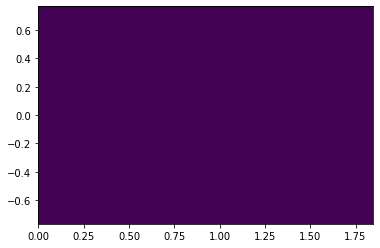

In [31]:
tmin = 0
tmax = 250
for idx, t in enumerate(range(tmin, tmax - window_size)):
    window_min = t
    window_max = t + window_size

    x = xs[(ts > window_min) & (ts < window_max)]
    y = ys[(ts > window_min) & (ts < window_max)]
    tmp_img = density_map(x, y, stats=False)

    if idx == 0:
        img = tmp_img
    else:
        img = np.fmax(tmp_img, img)

if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
else:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

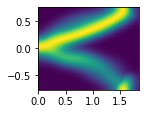

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(post0_x, post1_y * 2))
if isolation_type == 'short_noise':
    plt.imshow(
        img,
        extent=[0, post0_x, post0_y, post1_y],
#         vmax=len(np.unique(df_mid["event"]))
#             / len(np.unique(df_short["event"]))
    )
elif isolation_type == 'long_noise':
    plt.imshow(
        img,
        extent=[0, post0_x, post0_y, post1_y],
        vmax=len(np.unique(df_mid["event"]))
            / len(np.unique(df_long["event"]))
    )
else:
    plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
plt.xticks([0, 0.5, 1, 1.5])

if isolation_type == 'short_noise':
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_post_direct_tracks.pdf",
        dpi=600,
        bbox_inches="tight",
    )
elif isolation_type == 'signal':
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_post_bifurcation_tracks.pdf",
        dpi=600,
        bbox_inches="tight",
    )
else:
    plt.savefig(
        "/mnt/ssd1/Documents/Vivek/locustVR/"
        + str(nPosts)
        + "_post_noisy_tracks.pdf",
        dpi=600,
        bbox_inches="tight",
    )

### Identify bifurcation point using a piecewise phase-transition function

#### Get first bifurcation point
Once you have this, you can draw a line segment bisecting the angle between the point and two targets. This will be the line about which you symmetrise to get the second bifurcation point

In [33]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)


def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # This is added back by InteractiveShellApp.init_path()


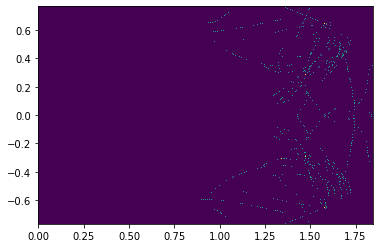

In [34]:
x_fit = []
y_fit = []

bif_pt = 1
params1 = [1.2, 1, 1]
    
x_sub = np.concatenate((xs1, xs1))
y_sub = np.concatenate((ys1, -ys1))
t_sub = np.concatenate((ts1, ts1))

tmin = 0
tmax = 250
for idx, t in enumerate(range(tmin, tmax-window_size)):
    window_min = t
    window_max = t + window_size

    x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
    y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
    tmp_img2 = density_map(x, y, stats=True)

    if idx == 0:
        tmp_img = tmp_img2
    else:
        tmp_img = np.fmax(tmp_img2, tmp_img)

x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
y_fit = (
    np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
)

x_fit = x_fit
y_fit = np.abs(y_fit)
y_fit = y_fit[x_fit > bif_pt]
x_fit = x_fit[x_fit > bif_pt]

for i in range(0, 10):
    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
    )
    params1 = fit_params

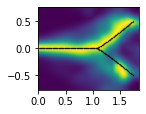

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(post0_x, post1_y*2))
plt.imshow(img ** 2, extent=[0, post0_x, post0_y, post1_y])


parameters = params1
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = (
    np.arange(parameters[0], post0_x - 10*step_len, step_len)
    )
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1],
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)

plt.scatter(x1, y1, c="black", s=0.1)
plt.scatter(x2, y2, c="black", s=0.1)
plt.xticks([0, 0.5, 1, 1.5])

fig.savefig(
    "/mnt/ssd1/Documents/Vivek/locustVR/"
    + str(nPosts)
    + "_post_bifurcation_quantified.pdf",
    dpi=600,
    bbox_inches="tight",
)

In [36]:
print(
    "The bifurcation occurs at an angle",
    2 * np.arctan2(post1_y, post1_x - params1[0]) * 180 / np.pi
)


The bifurcation occurs at an angle 89.18780070210381
